In [1]:
import os
import cv2
import sys
import math
import time
# import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from torch import np
from torch.autograd import Variable

from utils import *
from pose_estimation import *
from scipy.ndimage.filters import gaussian_filter

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 初始化关节参数

In [2]:
# find connection in the specified sequence, center 29 is in the position 15
limb_seq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], 
            [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], 
            [1,16], [16,18], [3,17], [6,18]]
           
# the middle joints heatmap correpondence
map_ids = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], [19,20], [21,22], 
           [23,24], [25,26], [27,28], [29,30], [47,48], [49,50], [53,54], [51,52], 
           [55,56], [37,38], [45,46]]
          
# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], 
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], 
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]

use_gpu = True

### 获取 PAF 和 Heat Map

In [3]:
def get_paf_and_heatmap(model, img_raw, scale_search, param_stride=8, box_size=368):
    
    multiplier = [scale * box_size / img_raw.shape[0] for scale in scale_search]

    heatmap_avg = torch.zeros((len(multiplier), 19, img_raw.shape[0], img_raw.shape[1])).cuda()
    paf_avg = torch.zeros((len(multiplier), 38, img_raw.shape[0], img_raw.shape[1])).cuda()

    for i, scale in enumerate(multiplier):

        img_test = cv2.resize(img_raw, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
        img_test_pad, pad = pad_right_down_corner(img_test, param_stride, param_stride)
        img_test_pad = np.transpose(np.float32(img_test_pad[:, :, :, np.newaxis]), (3, 2, 0, 1)) / 256 - 0.5

        feed = Variable(torch.from_numpy(img_test_pad)).cuda()
        output1, output2 = model(feed)

        print(output1.size())
        print(output2.size())

        heatmap = nn.UpsamplingBilinear2d((img_raw.shape[0], img_raw.shape[1])).cuda()(output2)

        paf = nn.UpsamplingBilinear2d((img_raw.shape[0], img_raw.shape[1])).cuda()(output1)

        heatmap_avg[i] = heatmap[0].data
        paf_avg[i] = paf[0].data

    heatmap_avg = torch.transpose(torch.transpose(torch.squeeze(torch.mean(heatmap_avg, 0)), 0, 1), 1, 2).cuda()
    heatmap_avg = heatmap_avg.cpu().numpy()

    paf_avg = torch.transpose(torch.transpose(torch.squeeze(torch.mean(paf_avg, 0)), 0, 1), 1, 2).cuda()
    paf_avg = paf_avg.cpu().numpy()
    
    return paf_avg, heatmap_avg

### 提取 Heat Map 内信息

In [4]:
def extract_heatmap_info(heatmap_avg, param_thre1=0.1):
    all_peaks = []
    peak_counter = 0

    for part in range(18):
        map_ori = heatmap_avg[:,:,part]
        map_gau = gaussian_filter(map_ori, sigma=3)

        map_left = np.zeros(map_gau.shape)
        map_left[1:,:] = map_gau[:-1,:]
        map_right = np.zeros(map_gau.shape)
        map_right[:-1,:] = map_gau[1:,:]
        map_up = np.zeros(map_gau.shape)
        map_up[:,1:] = map_gau[:,:-1]
        map_down = np.zeros(map_gau.shape)
        map_down[:,:-1] = map_gau[:,1:]

        peaks_binary = np.logical_and.reduce(
            (map_gau >= map_left, map_gau >= map_right, map_gau >= map_up, 
             map_gau >= map_down, map_gau > param_thre1))

        peaks = zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]) # note reverse
        peaks = list(peaks)
        peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
        ids = range(peak_counter, peak_counter + len(peaks))
        peaks_with_score_and_id = [peaks_with_score[i] + (ids[i],) for i in range(len(ids))]

        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    
    return all_peaks

### 提取 PAF 信息

In [5]:
def extract_paf_info(img_raw, paf_avg, all_peaks, param_thre2=0.05, param_thre3=0.5):

    connection_all = []
    special_k = []
    mid_num = 10

    for k in range(len(map_ids)):
        score_mid = paf_avg[:, :, [x - 19 for x in map_ids[k]]]
        candA = all_peaks[limb_seq[k][0] - 1]
        candB = all_peaks[limb_seq[k][1] - 1]
        nA = len(candA)
        nB = len(candB)
        if nA != 0 and nB != 0:
            connection_candidate = []
            for i in range(nA):
                for j in range(nB):
                    vec = np.subtract(candB[j][:2], candA[i][:2])
                    norm = math.sqrt(vec[0] * vec[0] + vec[1] * vec[1])
                    vec = np.divide(vec, norm)

                    startend = zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), 
                                   np.linspace(candA[i][1], candB[j][1], num=mid_num))
                    startend = list(startend)

                    vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] 
                                      for I in range(len(startend))])
                    vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] 
                                      for I in range(len(startend))])

                    score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                    score_with_dist_prior = sum(score_midpts) / len(score_midpts)
                    score_with_dist_prior += min(0.5 * img_raw.shape[0] / norm - 1, 0)
                    
                    criterion1 = len(np.nonzero(score_midpts > param_thre2)[0]) > 0.8 * len(score_midpts)
                    criterion2 = score_with_dist_prior > 0
                    if criterion1 and criterion2:
                        connection_candidate.append(
                            [i, j, score_with_dist_prior, score_with_dist_prior + candA[i][2] + candB[j][2]])

            connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
            connection = np.zeros((0, 5))
            for c in range(len(connection_candidate)):
                i, j, s = connection_candidate[c][0:3]
                if i not in connection[:, 3] and j not in connection[:, 4]:
                    connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                    if len(connection) >= min(nA, nB):
                        break

            connection_all.append(connection)
        else:
            special_k.append(k)
            connection_all.append([])

    return special_k, connection_all

### 获得人体关键点

In [6]:
def get_subsets(connection_all, special_k, all_peaks):
    # last number in each row is the total parts number of that person
    # the second last number in each row is the score of the overall configuration
    subset = -1 * np.ones((0, 20))
    candidate = np.array([item for sublist in all_peaks for item in sublist])

    for k in range(len(map_ids)):
        if k not in special_k:
            partAs = connection_all[k][:,0]
            partBs = connection_all[k][:,1]
            indexA, indexB = np.array(limb_seq[k]) - 1

            for i in range(len(connection_all[k])): #= 1:size(temp,1)
                found = 0
                subset_idx = [-1, -1]
                for j in range(len(subset)): #1:size(subset,1):
                    if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                        subset_idx[found] = j
                        found += 1

                if found == 1:
                    j = subset_idx[0]
                    if(subset[j][indexB] != partBs[i]):
                        subset[j][indexB] = partBs[i]
                        subset[j][-1] += 1
                        subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
                elif found == 2: # if found 2 and disjoint, merge them
                    j1, j2 = subset_idx
                    print("found = 2")
                    membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                    if len(np.nonzero(membership == 2)[0]) == 0: #merge
                        subset[j1][:-2] += (subset[j2][:-2] + 1)
                        subset[j1][-2:] += subset[j2][-2:]
                        subset[j1][-2] += connection_all[k][i][2]
                        subset = np.delete(subset, j2, 0)
                    else: # as like found == 1
                        subset[j1][indexB] = partBs[i]
                        subset[j1][-1] += 1
                        subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(20)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    row[-1] = 2
                    row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                    subset = np.vstack([subset, row])
    return subset, candidate

### 画出关键点

In [7]:
def draw_key_point(subset, all_peaks, img_raw):
    
    del_ids = []
    for i in range(len(subset)):
        if subset[i][-1] < 4 or subset[i][-2] / subset[i][-1] < 0.4:
            del_ids.append(i)
    subset = np.delete(subset, del_ids, axis=0)

    img_canvas = img_raw.copy()

    for i in range(18):
        for j in range(len(all_peaks[i])):
            cv2.circle(img_canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

    return subset, img_canvas

### 连接关键点

In [8]:
def link_key_point(img_canvas, candidate, subset, stickwidth=4):
    for i in range(17):
        for n in range(len(subset)):
            index = subset[n][np.array(limb_seq[i])-1]
            if -1 in index:
                continue
            cur_canvas = img_canvas.copy()
            Y = candidate[index.astype(int), 0]
            X = candidate[index.astype(int), 1]
            mX = np.mean(X)
            mY = np.mean(Y)
            length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
            angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
            polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
            cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
            img_canvas = cv2.addWeighted(img_canvas, 0.4, cur_canvas, 0.6, 0)

    return img_canvas

### 加载测试图片

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 35.2 ms


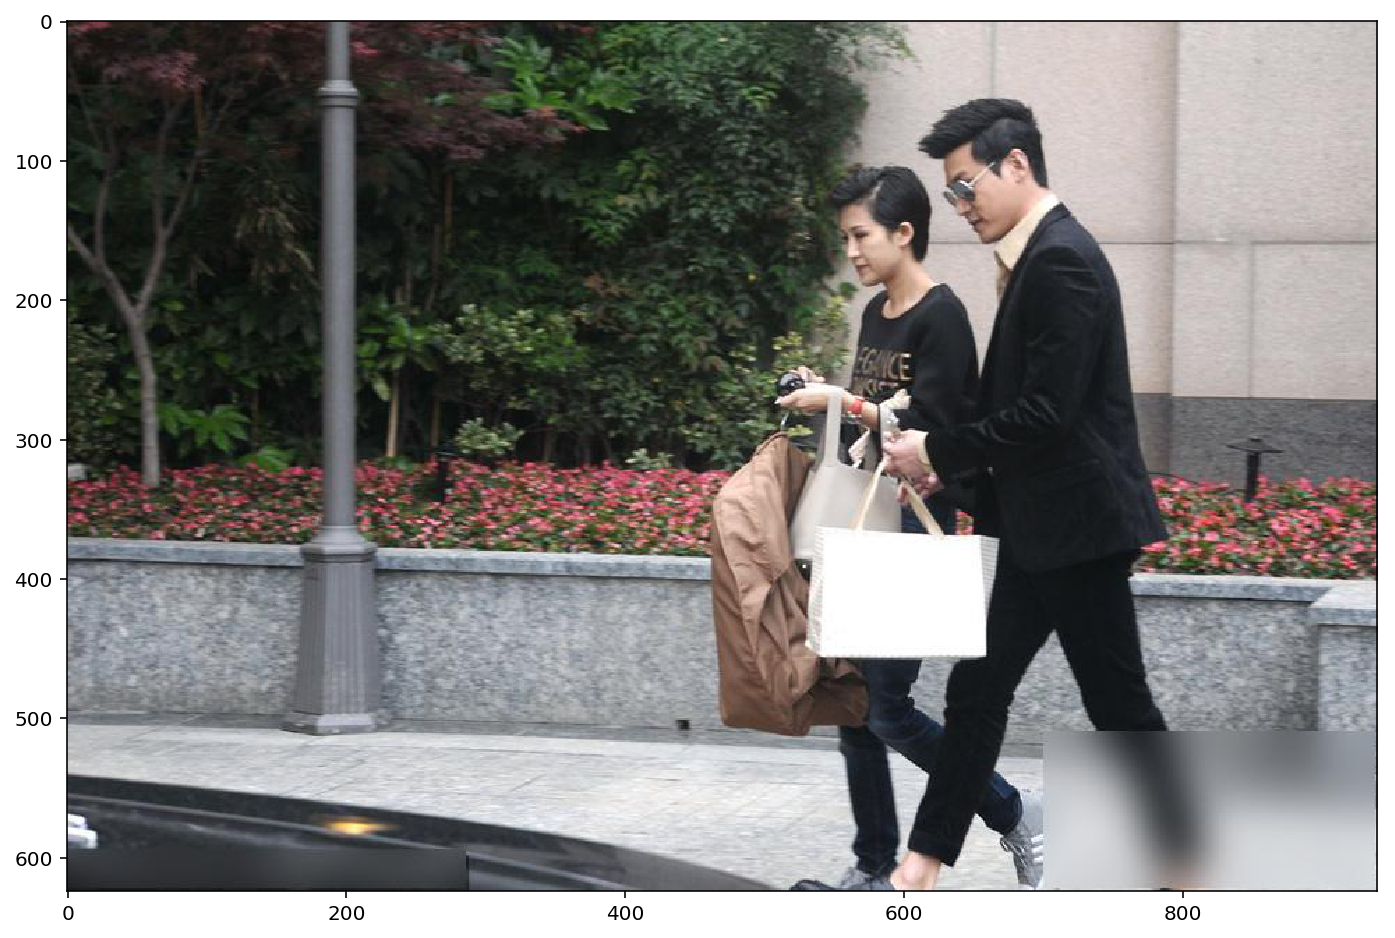

In [9]:
%%time

test_image = './test.jpg'
img_ori = cv2.imread(test_image) # B,G,R order

# display the validation pics
plt.figure(figsize=(12, 8))
plt.imshow(img_ori[...,::-1])

### 加载模型

In [10]:
state_dict = torch.load('./models/coco_pose_iter_440000.pth.tar')['state_dict']

model_pose = get_pose_model()
model_pose.load_state_dict(state_dict)
model_pose.float()
model_pose.eval()

PoseEstimation (
  (model0): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU (inplace)
    (18): MaxPool2

### 使用 GPU

In [11]:
if use_gpu:
    model_pose.cuda()
    model_pose = torch.nn.DataParallel(model_pose, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

### 获取 PAF 和 Heat Map

In [12]:
%%time

scale_param = [0.5, 1.0, 1.5, 2.0]
paf_info, heatmap_info = get_paf_and_heatmap(model_pose, img_ori, scale_param)

torch.Size([1, 38, 23, 35])
torch.Size([1, 19, 23, 35])


/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:183: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


torch.Size([1, 38, 46, 70])
torch.Size([1, 19, 46, 70])
torch.Size([1, 38, 69, 104])
torch.Size([1, 19, 69, 104])
torch.Size([1, 38, 92, 139])
torch.Size([1, 19, 92, 139])
CPU times: user 1.52 s, sys: 2.22 s, total: 3.74 s
Wall time: 9 s


In [13]:
%%time

peaks = extract_heatmap_info(heatmap_info)

CPU times: user 432 ms, sys: 0 ns, total: 432 ms
Wall time: 434 ms


In [14]:
%%time

sp_k, con_all = extract_paf_info(img_ori, paf_info, peaks)

CPU times: user 148 ms, sys: 0 ns, total: 148 ms
Wall time: 146 ms


In [15]:
%%time

subsets, candidates = get_subsets(con_all, sp_k, peaks)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 287 µs


CPU times: user 72 ms, sys: 0 ns, total: 72 ms
Wall time: 72.5 ms


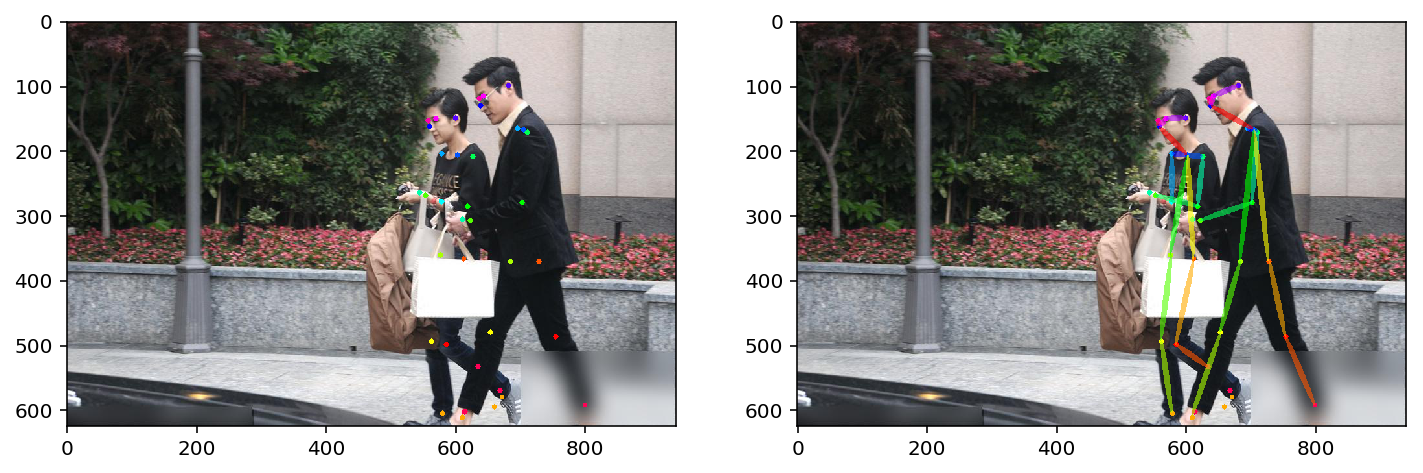

In [16]:
%%time

subsets, img_points = draw_key_point(subsets, peaks, img_ori)
img_canvas = link_key_point(img_points, candidates, subsets)

# cv2.imwrite('result.png', img_canvas)   

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(img_points[...,::-1])

plt.subplot(1, 2, 2)
plt.imshow(img_canvas[...,::-1])